# Sentiment Analysis of Amazon Fine Food Reviews

## Context

This dataset consists of customer reviews of fine food products collected from Amazon. The data spans a period of more than 10 years, covering reviews from October 1999 to October 2012, and includes approximately 568,000 reviews.

Each review contains product and user information, a numerical rating, and a plain text review expressing the customer’s opinion. In addition to fine food products, the dataset also includes reviews from other Amazon categories.

## Contents

- **database.sqlite**: Contains the table `Reviews`

## Data Includes

- Reviews from **October 1999 to October 2012**
- **568,454** total reviews
- **256,059** unique users
- **74,258** unique products
- **260** users with more than **50 reviews**


In [344]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [259]:
import nltk
import string
import sqlite3

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [260]:
con = sqlite3.connect("database.sqlite")
con

In [261]:
# Load the data
df = pd.read_sql_query(""" select * from reviews where Score != 3 """,con)
df.shape

(525814, 10)

In [262]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [263]:
# Check the distribution of review scores before mapping
df['Score'].value_counts()
# 5 and 4 are positive reviews, 1 and 2 are negative reviews

Score
5    363122
4     80655
1     52268
2     29769
Name: count, dtype: int64

In [264]:
# Convert the numerical 'Score' into binary sentiment
# 1 → Positive (Score > 3), 0 → Negative (Score <= 3)

df['Score'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [265]:
# Checking the distribution of binary sentiment
df['Score'].value_counts()

Score
1    443777
0     82037
Name: count, dtype: int64

In [266]:
# Check the percentage of each class (helps identify class imbalance)
df['Score'].value_counts() / len(df) * 100

Score
1    84.398095
0    15.601905
Name: count, dtype: float64

In [267]:
# Check for duplicate rows in the dataset
# Since sum().sum() is 0, there are no duplicate rows
df.duplicated().sum().sum()

0

In [268]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [269]:
# Filter out reviews where HelpfulnessNumerator > HelpfulnessDenominator
# This ensures the helpfulness vote data is logically consistent
final = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator]

In [270]:
# Preview the first 3 rows after filtering
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [271]:
# Check the shape of the filtered dataset
final.shape 

(525812, 10)

In [272]:
# Sample text data from different rows to inspect review content
# Helps understand the nature of reviews for preprocessing

# List of row indices to sample
sample_indices = [0, 100, 2500, 4500, 30000,50000,100000,200000]

samples = {}

for i, idx in enumerate(sample_indices, start=1):
    key = f"sent_{i}"  
    samples[key] = final['Text'].values[idx]
    print(f"{key}:")
    print(samples[key])
    print("-" * 100)

sent_1:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
----------------------------------------------------------------------------------------------------
sent_2:
I was diappointed in the flavor and texture of this mix.  I usually like most of the Low Carb things I have tried, but was diappointed in this specific one.
----------------------------------------------------------------------------------------------------
sent_3:
The small, white popcorn is the best!  Very delicious - and I've tried lots.
----------------------------------------------------------------------------------------------------
sent_4:
My husband and I both like coffee with rich flavor and good taste, but we do not like the bitter or burnt taste some coffees have.  This Community Hazelnut has excelle

In [273]:
# initialize lemmatizer and stopword list
lemmatizer = WordNetLemmatizer()

stopwords = set(stopwords.words('english'))

In [274]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [275]:
len(stopwords)

198

### Step 2 - Text Preprocessing

In [276]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

In [277]:
preprocessed_reviews = []

for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ' '.join(lemmatizer.lemmatize(word.lower()) for word in sentence.split() if word.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    

100%|████████████████████████████████████████████████████████████████████████| 525812/525812 [02:37<00:00, 3348.71it/s]


In [278]:
# Preview original vs preprocessed review

def preview_review(idx):
    print(f"Original Review : {final['Text'][idx][:300]}")
    print()
    print(f"Preprocessed Review : {preprocessed_reviews[idx][:300]}")
    print("-"*100)

# Example usage
preview_review(0)
preview_review(100)
preview_review(2500)


Original Review : I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Preprocessed Review : bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better
----------------------------------------------------------------------------------------------------
Original Review : I was diappointed in the flavor and texture of this mix.  I usually like most of the Low Carb things I have tried, but was diappointed in this specific one.

Preprocessed Review : diappointed flavor texture mix usually like low carb thing tried diappointed specific one
----------------------------------------------------------------------------------------------------
Original Review : The small, white popcorn 

### Step 3 - Feature Extraction (TF-IDF)

In [313]:
# convert text data into numerical data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)

In [314]:
# Store target variable (labels) separately
y = final['Score']

# Store feature data
x = preprocessed_reviews

In [315]:
# Fit transform the training data
# - stratify=y preserves class distribution in train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43, stratify = y)

In [316]:
# Fit TF - IDF on the training data and transform training text

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

x_test_tfidf = tfidf_vectorizer.transform(x_test)

print(f"Shape of TF-IDF training data: {x_train_tfidf.shape}")
print(f"Shape of TF-IDF testing data: {x_test_tfidf.shape}")
print("")
print(f"First 5 feature names: {tfidf_vectorizer.get_feature_names_out()[1500:1550]}")

Shape of TF-IDF training data: (420649, 539096)
Shape of TF-IDF testing data: (105163, 539096)

First 5 feature names: ['acid protect' 'acid protein' 'acid provides' 'acid pryidoxine'
 'acid pyridoxine' 'acid pyrophosphate' 'acid rapeseed' 'acid rat'
 'acid really' 'acid reason' 'acid reflex' 'acid reflux' 'acid refluxing'
 'acid regular' 'acid riboflavin' 'acid rich' 'acid rose' 'acid rosemary'
 'acid salmon' 'acid salt' 'acid smooth' 'acid sodium' 'acid something'
 'acid sorbic' 'acid source' 'acid soy' 'acid spice' 'acid starter'
 'acid stomach' 'acid strawberry' 'acid strong' 'acid subdue' 'acid sugar'
 'acid supplement' 'acid sure' 'acid taste' 'acid think' 'acid though'
 'acid tomato' 'acid toxic' 'acid tummy' 'acid united' 'acid unlike'
 'acid use' 'acid used' 'acid vitamin' 'acid water' 'acid way' 'acid well'
 'acid whole']


### Step 4 - Model training (Naive Bayes, Logistic Regression, and SVM)

In [333]:
nb_classifier = MultinomialNB()

nb_classifier.fit(x_train_tfidf, y_train)

print(f'Naive bayes trained')

lr_classifier = LogisticRegression(solver='liblinear',random_state=42,C=1,class_weight='balanced',max_iter=1000)
lr_classifier.fit(x_train_tfidf, y_train)

print(f'Logistic Regression trained')

svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(x_train_tfidf, y_train)

print(f'Linear SVM trained')

Naive bayes trained
Logistic Regression trained
SVM trained


### Step 5 - Model Evaluation

In [334]:
# Function to print training and testing accuracy
def print_train_test_accuracy(classifier, x_train_features, y_train_labels,
                              x_test_features, y_test_labels, model_name="Model"):
    
    # Training accuracy
    train_pred = classifier.predict(x_train_features)
    train_accuracy = accuracy_score(y_train_labels, train_pred)
    
    # Testing accuracy
    test_pred = classifier.predict(x_test_features)
    test_accuracy = accuracy_score(y_test_labels, test_pred)
    
    print(f"{model_name} Training Accuracy : {train_accuracy}")
    print(f"{model_name} Test Accuracy     : {test_accuracy}")
    print("-" * 60)


In [335]:
# Naive Bayes accuracies
print_train_test_accuracy(
    nb_classifier,
    x_train_tfidf, y_train,
    x_test_tfidf, y_test,
    "Naive Bayes"
)

# Logistic Regression accuracies
print_train_test_accuracy(
    lr_classifier,
    x_train_tfidf, y_train,
    x_test_tfidf, y_test,
    "Logistic Regression"
)

# SVM accuracies
print_train_test_accuracy(
    svm_model,
    x_train_tfidf, y_train,
    x_test_tfidf, y_test,
    "Linear SVM"
)

Naive Bayes Training Accuracy : 0.9047353018787635
Naive Bayes Test Accuracy     : 0.8911214020140164
------------------------------------------------------------
Logistic Regression Training Accuracy : 0.9559775489778889
Logistic Regression Test Accuracy     : 0.9389709308406949
------------------------------------------------------------
Linear SVM Training Accuracy : 0.9939831070560016
Linear SVM Test Accuracy     : 0.9583503703774141
------------------------------------------------------------


In [336]:

def evaluate_model(classifier, x_test_features, y_test_labels, model_name = "Model"):
  y_pred = classifier.predict(x_test_features)

  # calculate the accuracy
  accuracy = accuracy_score(y_test_labels, y_pred)
  print(f"accuracy score {model_name}: {accuracy}")

  # generate classification report
  print(f"Classification report for Model : {model_name}")
  print(classification_report(y_test_labels, y_pred, target_names=['Negative (0)', 'Positive (1)']))

  # Generate the confusion matrix
  print(f"Confusion Matrix for Model : {model_name}")
  cm = confusion_matrix(y_test_labels, y_pred)
  print(cm)
     

In [337]:
# Evaluate Naive Bayes
evaluate_model(nb_classifier,x_test_tfidf, y_test, "Naive Bayes")

accuracy score Naive Bayes: 0.8911214020140164
Classification report for Model : Naive Bayes
              precision    recall  f1-score   support

Negative (0)       0.98      0.31      0.47     16407
Positive (1)       0.89      1.00      0.94     88756

    accuracy                           0.89    105163
   macro avg       0.93      0.65      0.70    105163
weighted avg       0.90      0.89      0.87    105163

Confusion Matrix for Model : Naive Bayes
[[ 5080 11327]
 [  123 88633]]


In [338]:
# Evaluate Logistic Regression
evaluate_model(lr_classifier, x_test_tfidf, y_test, "Logistic Regression")

accuracy score Logistic Regression: 0.9389709308406949
Classification report for Model : Logistic Regression
              precision    recall  f1-score   support

Negative (0)       0.75      0.91      0.82     16407
Positive (1)       0.98      0.94      0.96     88756

    accuracy                           0.94    105163
   macro avg       0.87      0.93      0.89    105163
weighted avg       0.95      0.94      0.94    105163

Confusion Matrix for Model : Logistic Regression
[[15004  1403]
 [ 5015 83741]]


In [339]:
# Evaluate Linear SVM 
evaluate_model(svm_model, x_test_tfidf, y_test, "Linear SVM")

accuracy score Linear SVM: 0.9583503703774141
Classification report for Model : Linear SVM
              precision    recall  f1-score   support

Negative (0)       0.85      0.89      0.87     16407
Positive (1)       0.98      0.97      0.98     88756

    accuracy                           0.96    105163
   macro avg       0.92      0.93      0.92    105163
weighted avg       0.96      0.96      0.96    105163

Confusion Matrix for Model : Linear SVM
[[14579  1828]
 [ 2552 86204]]


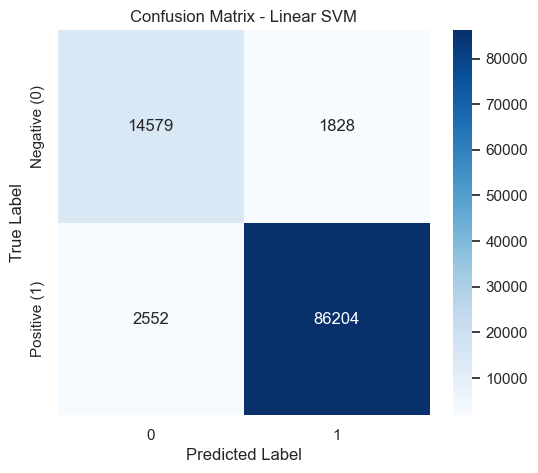

In [342]:
# Predict on test data
y_pred_svm = svm_model.predict(x_test_tfidf)

# Generate confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Linear SVM')
plt.show()

In [343]:

# Save Linear SVM model
joblib.dump(svm_model, "svm_amazon_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']